In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

In [3]:
raw_path = "events_data.csv"
clean_path = "cleaned_events.csv"

df_raw = pd.read_csv(raw_path, low_memory=False)
df_clean = pd.read_csv(clean_path, low_memory=False)

print(f"Raw: {len(df_raw):,} rows × {df_raw.shape[1]} columns")
print(f"Cleaned: {len(df_clean):,} rows × {df_clean.shape[1]} columns")

Raw: 134,911 rows × 27 columns
Cleaned: 134,911 rows × 23 columns


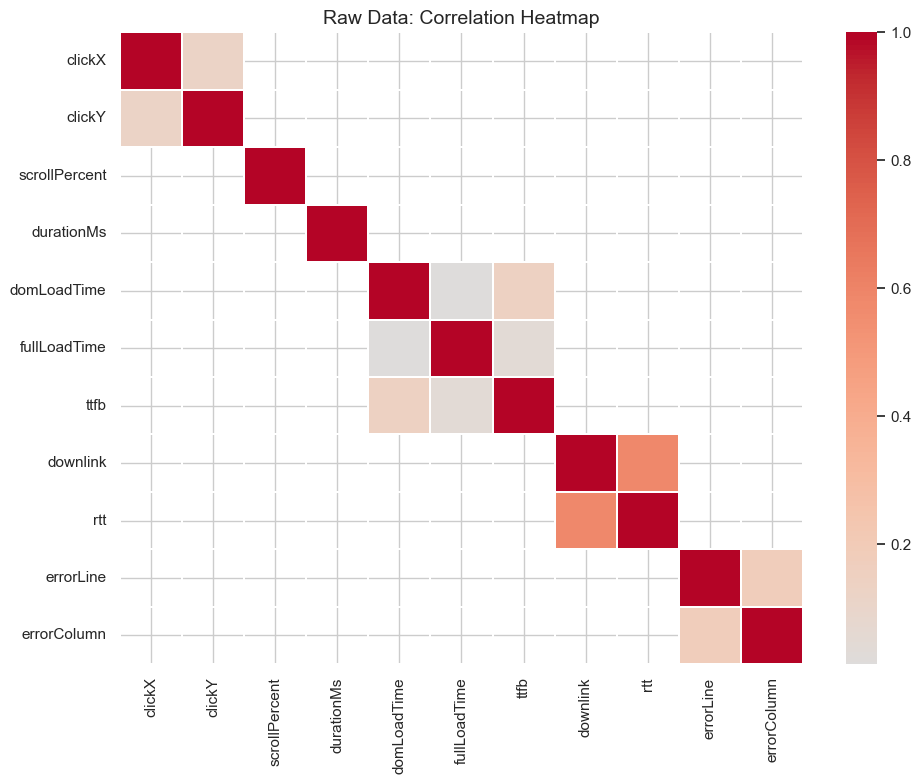

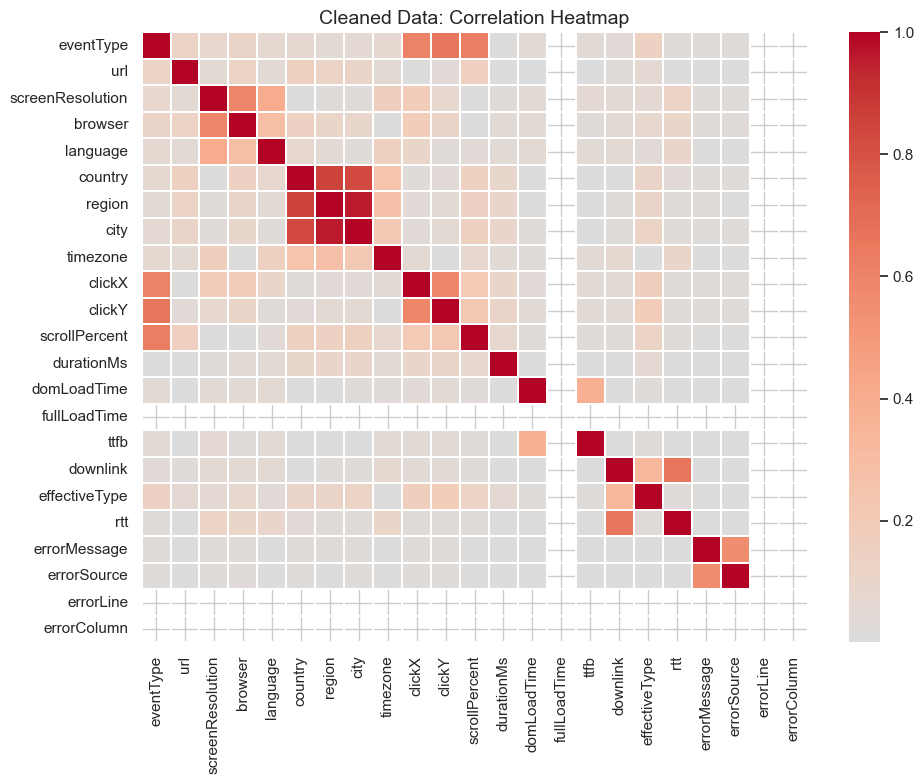

In [5]:
# Correlation Heatmap Comparison
# ============================================================
def plot_corr_heatmap(df, title):
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr().abs()
    sns.heatmap(corr, cmap="coolwarm", cbar=True, center=0, linewidths=0.3)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(df_raw, "Raw Data: Correlation Heatmap")
plot_corr_heatmap(df_clean, "Cleaned Data: Correlation Heatmap")

In [6]:
# Quick Feature Importance (LightGBM)
# ============================================================
# 1 Choose a target variable
# Example: predicting whether an event is a page_view vs others
if "eventType" in df_clean.columns:
    y = (df_clean["eventType"] == df_clean["eventType"].max()).astype(int)
    X = df_clean.drop(columns=["eventType"], errors="ignore")
else:
    # fallback if eventType is removed
    y = np.random.randint(0, 2, len(df_clean))
    X = df_clean.copy()

# 2 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3 LightGBM model (classifier for categorical or binary target)
model = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"✅ LightGBM model trained successfully — Accuracy: {acc:.4f}")

[LightGBM] [Info] Number of positive: 18182, number of negative: 89746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 107928, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168464 -> initscore=-1.596551
[LightGBM] [Info] Start training from score -1.596551
✅ LightGBM model trained successfully — Accuracy: 0.9991


C:\Users\KAVI\AppData\Local\Temp\ipykernel_9764\190512976.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


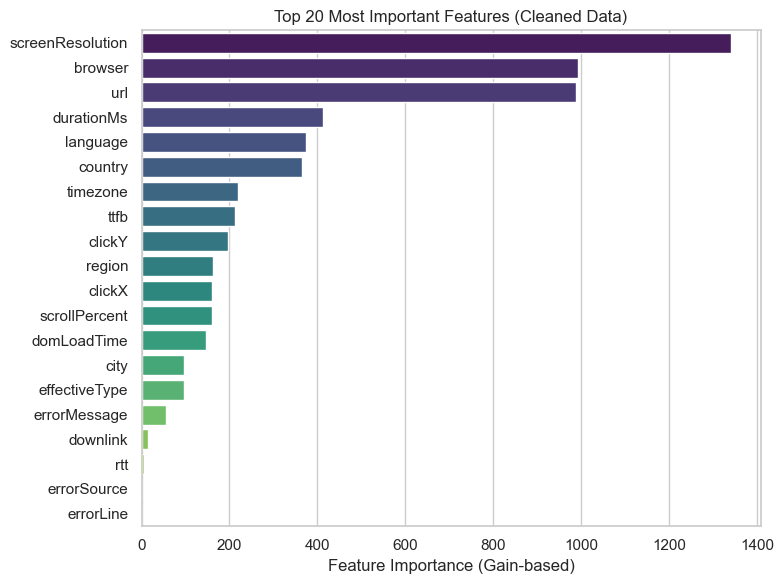

In [8]:
# Feature Importance Visualization
# ============================================================
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(
    y="Feature", x="Importance",
    data=importance_df, palette="viridis"
)
plt.title("Top 20 Most Important Features (Cleaned Data)")
plt.xlabel("Feature Importance (Gain-based)")
plt.ylabel("")
plt.tight_layout()
plt.show()

C:\Users\KAVI\AppData\Local\Temp\ipykernel_9764\2987590650.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


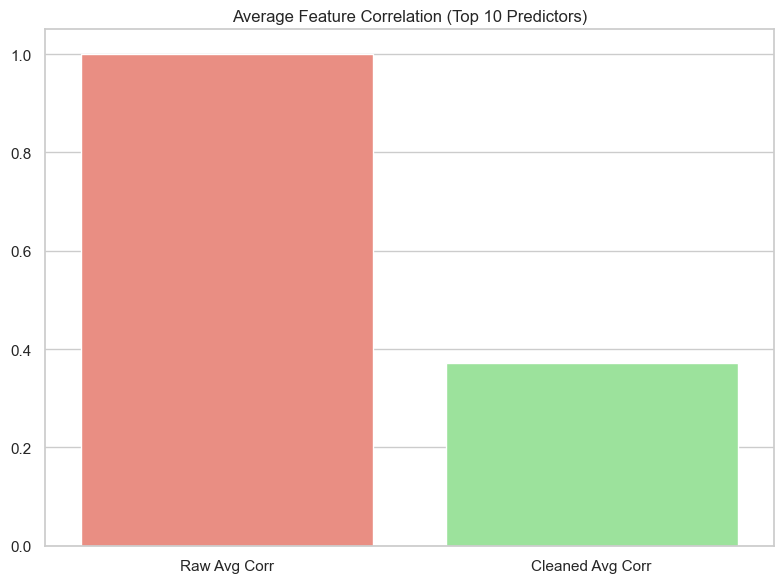

Average correlation among top features — Raw: 1.000 | Cleaned: 0.371


In [15]:
# Correlation vs. Feature Importance Insight

# Take top 10 features from cleaned model
top_features = importance_df["Feature"].head(10)

# Select only numeric columns from both datasets
num_raw = df_raw.select_dtypes(include=[np.number])
num_clean = df_clean.select_dtypes(include=[np.number])

# Filter to overlapping features
common_features = [f for f in top_features if f in num_raw.columns and f in num_clean.columns]

if len(common_features) >= 2:
    raw_corr = num_raw[common_features].corr().abs().mean().mean()
    clean_corr = num_clean[common_features].corr().abs().mean().mean()
else:
    raw_corr, clean_corr = np.nan, np.nan

plt.figure(figsize=(8, 6))
sns.barplot(
    x=["Raw Avg Corr", "Cleaned Avg Corr"],
    y=[raw_corr if not np.isnan(raw_corr) else 0, clean_corr if not np.isnan(clean_corr) else 0],
    palette=["salmon", "lightgreen"]
)
plt.title("Average Feature Correlation (Top 10 Predictors)")
plt.tight_layout()
plt.show()

if not np.isnan(raw_corr):
    print(f"Average correlation among top features — Raw: {raw_corr:.3f} | Cleaned: {clean_corr:.3f}")
else:
    print("⚠️ Skipped correlation comparison: insufficient numeric overlap between raw and cleaned datasets.")